# Hematopoiesis

Hematopoiesis dataset from *Weinreb, C., Rodriguez-Fraticelli, A., Camargo, F. D. & Klein, A. M. Science 367, (2020)*. 

This dataset has 3 time points for both the clonal and state measurements. It has ~50000 clonally-labeled cells. Running the whole pipeline for the first time could take 5.2 hours in a standard personal computer.
Most of the time (3.3 h) is used for generating the similarity matrix, which are saved for later usage. 

**Key components:**
    
* Part I: Infer transition map from all clonal data
    
* Part II: Infer transition using end-point clones
    
* Part III: Infer transition map from state information alone
    
* Part IV: Predict fate bias for Gata1+ states

In [1]:
import cospar as cs
import numpy as np

In [2]:
cs.logging.print_version()
cs.settings.verbosity = 2
cs.settings.data_path = "LARRY_data"  # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path = "LARRY_figure"  # A relative path to save figures. If not existed before, create a new one.
cs.settings.set_figure_params(
    format="png", figsize=[4, 3.5], dpi=75, fontsize=14, pointsize=2
)

Running cospar 0.2.0 (python 3.8.12) on 2022-02-07 21:21.


In [3]:
# # This is for testing this notebook
# cs.settings.data_path='data_cospar'
# cs.settings.figure_path='fig_cospar'
# adata_orig=cs.datasets.hematopoiesis_subsampled()
# adata_orig.uns['data_des']=['LARRY_sp500_ranking1']

## Loading data

In [4]:
adata_orig = cs.datasets.hematopoiesis()

In [5]:
adata_orig

AnnData object with n_obs × n_vars = 49116 × 25289
    obs: 'time_info', 'state_info'
    uns: 'clonal_time_points', 'data_des', 'state_info_colors'
    obsm: 'X_clone', 'X_emb', 'X_pca'

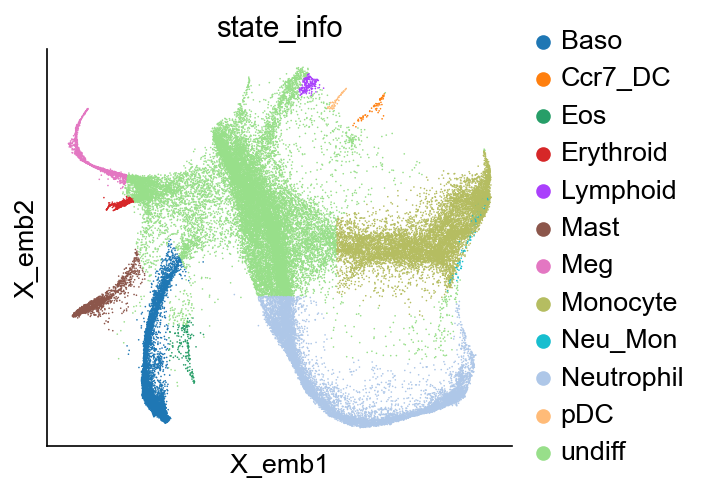

In [6]:
cs.pl.embedding(adata_orig, color="state_info")

In [7]:
cs.hf.check_available_choices(adata_orig)

Available transition maps: []
Available clusters: ['undiff', 'Meg', 'Mast', 'Neu_Mon', 'Eos', 'Erythroid', 'Ccr7_DC', 'Baso', 'Lymphoid', 'pDC', 'Neutrophil', 'Monocyte']
Available time points: ['2' '4' '6']
Clonal time points: ['2' '4' '6']


## Basic clonal analysis

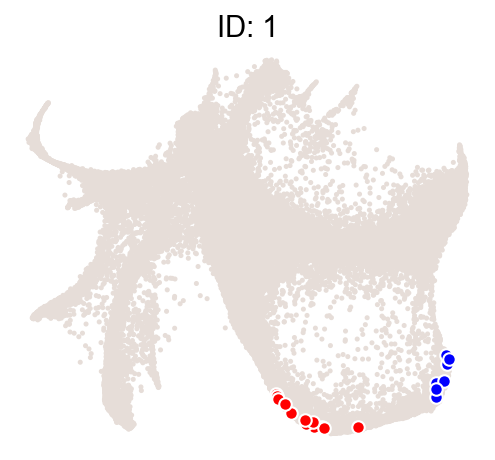

In [8]:
cs.pl.clones_on_manifold(
    adata_orig, selected_clone_list=[1], color_list=["black", "red", "blue"]
)

Results saved as dictionary at adata.uns['fate_coupling_X_clone']


<AxesSubplot:title={'center':'source: X_clone'}>

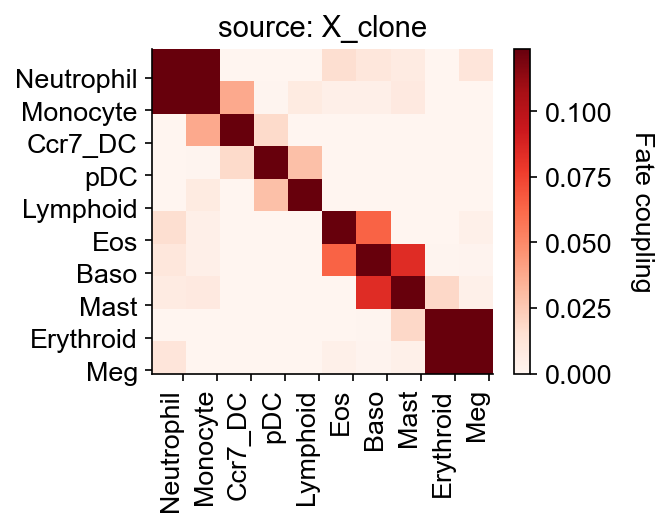

In [9]:
selected_times = "4"
selected_fates = [
    "Ccr7_DC",
    "Mast",
    "Meg",
    "pDC",
    "Eos",
    "Lymphoid",
    "Erythroid",
    "Baso",
    "Neutrophil",
    "Monocyte",
]
cs.tl.fate_coupling(
    adata_orig,
    source="X_clone",
    selected_fates=selected_fates,
    selected_times=selected_times,
    normalize=False,
)
cs.pl.fate_coupling(adata_orig, source="X_clone")

Data saved at adata.uns['barcode_heatmap']


<AxesSubplot:>

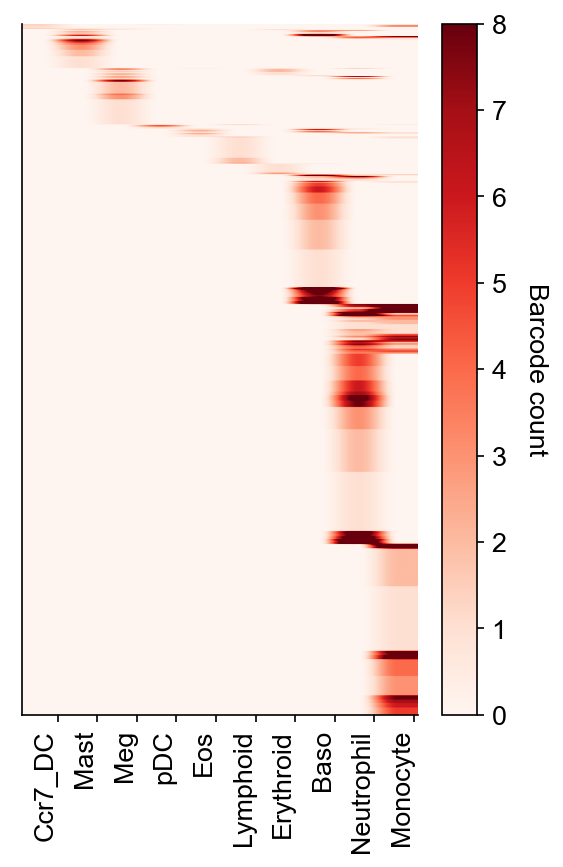

In [10]:
cs.pl.barcode_heatmap(
    adata_orig,
    selected_times=selected_times,
    selected_fates=selected_fates,
    color_bar=True,
)

## Part I: Infer transition map from all clonal data

### Map inference

When first run, it takes around 3 h 37 mins, in which 3 h 20 mins are used for computing the similarity matrices and saving these data. It takes only 20 mins for later runs.

In [11]:
adata = cs.tmap.infer_Tmap_from_multitime_clones(
    adata_orig,
    clonal_time_points=["2", "4", "6"],
    later_time_point="6",
    smooth_array=[20, 15, 10],
    sparsity_threshold=0.2,
    max_iter_N=3,
)

Trying to set attribute `.uns` of view, copying.


------Compute the full Similarity matrix if necessary------
------Infer transition map between initial time points and the later time one------
--------Current initial time point: 2--------
Step 1: Select time points
Number of multi-time clones post selection: 1216
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.903
--------Current initial time point: 4--------
Step 1: Select time points
Number of multi-time clones post selection: 3047
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.97
-----------Total used time: 1604.8337297439575 s ------------


### Save pre-computed data (optional)

In [12]:
save_data = False
if save_data:
    cs.hf.save_map(adata)

### Plotting


#### Transition profiles for single cells

Forward transitions with `map_backward=False`.

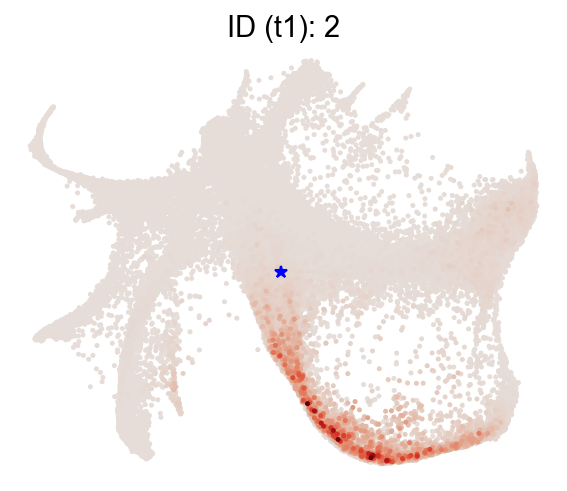

In [13]:
selected_state_id_list = [2]

cs.pl.single_cell_transition(
    adata,
    selected_state_id_list=selected_state_id_list,
    color_bar=False,
    source="transition_map",
    map_backward=False,
)

Backward transitions with `map_backward=True`.

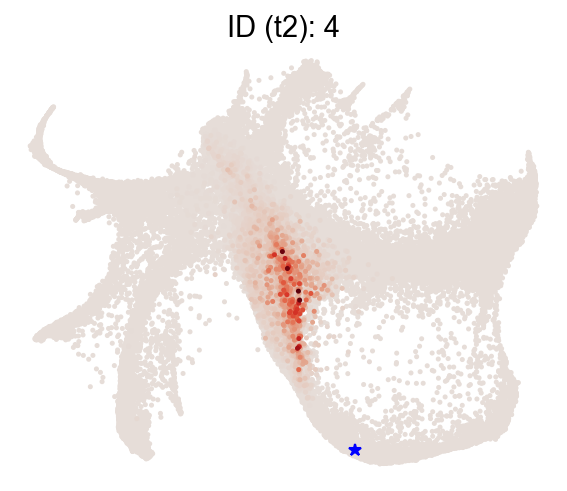

In [14]:
selected_state_id_list = [4]
cs.pl.single_cell_transition(
    adata,
    selected_state_id_list=selected_state_id_list,
    color_bar=False,
    source="transition_map",
    map_backward=True,
)

#### Fate map

Results saved at adata.obs['fate_map_transition_map_Neutrophil']
Results saved at adata.obs['fate_map_transition_map_Monocyte']


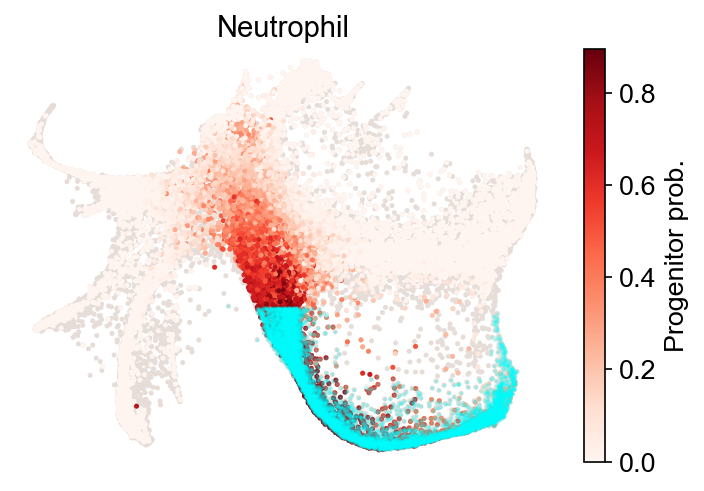

In [15]:
cs.tl.fate_map(
    adata,
    selected_fates=["Neutrophil", "Monocyte"],
    source="transition_map",
    map_backward=True,
)
cs.pl.fate_map(
    adata,
    selected_fates=["Neutrophil"],
    source="transition_map",
    plot_target_state=True,
    show_histogram=False,
)

#### Fate bias

Results saved at adata.obs['fate_map_transition_map_Neutrophil']
Results saved at adata.obs['fate_map_transition_map_Monocyte']
Results saved at adata.obs['fate_bias_transition_map_Neutrophil*Monocyte']


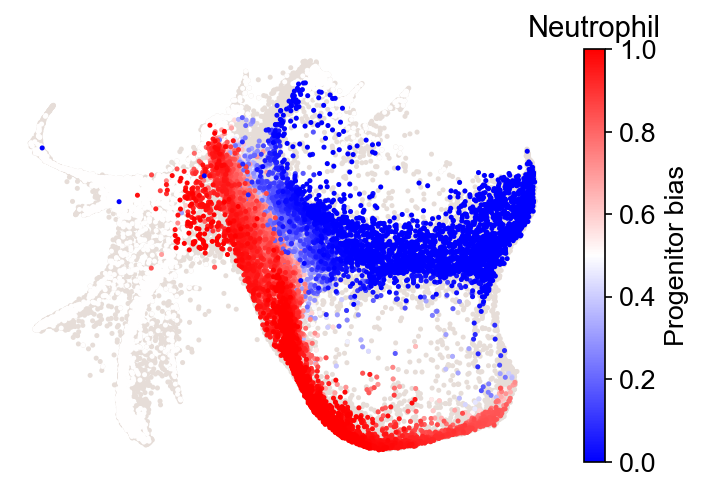

In [16]:
cs.tl.fate_bias(
    adata,
    selected_fates=["Neutrophil", "Monocyte"],
    source="transition_map",
    pseudo_count=0,
    sum_fate_prob_thresh=0.1,
)
cs.pl.fate_bias(
    adata,
    selected_fates=["Neutrophil", "Monocyte"],
    source="transition_map",
    plot_target_state=False,
    selected_times=["4"],
)

#### Fate coupling from the transition map

Results saved as dictionary at adata.uns['fate_coupling_transition_map']


<AxesSubplot:title={'center':'source: transition_map'}>

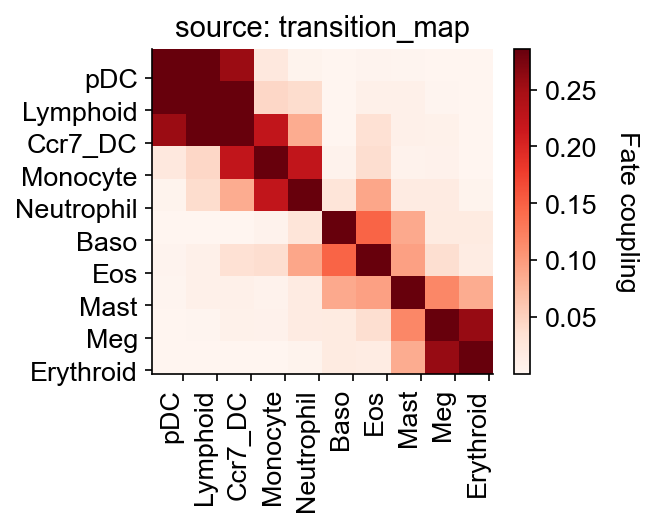

In [17]:
selected_fates = [
    "Ccr7_DC",
    "Mast",
    "Meg",
    "pDC",
    "Eos",
    "Lymphoid",
    "Erythroid",
    "Baso",
    "Neutrophil",
    "Monocyte",
]
cs.tl.fate_coupling(adata, selected_fates=selected_fates, source="transition_map")
cs.pl.fate_coupling(adata, source="transition_map")

#### Hierarchy

In [18]:
cs.tl.fate_hierarchy(adata, selected_fates=selected_fates, source="transition_map")
cs.pl.fate_hierarchy(adata, source="transition_map")

Results saved as dictionary at adata.uns['fate_hierarchy_transition_map']

            /-Erythroid
         /-|
      /-|   \-Meg
     |  |
   /-|   \-Mast
  |  |
  |  |   /-Baso
  |   \-|
--|      \-Eos
  |
  |      /-Monocyte
  |   /-|
  |  |   \-Neutrophil
   \-|
     |      /-Lymphoid
     |   /-|
      \-|   \-Ccr7_DC
        |
         \-pDC


#### Dynamic trajectory inference

Results saved at adata.obs['fate_map_transition_map_Neutrophil']
Results saved at adata.obs['fate_map_transition_map_Monocyte']
Results saved at adata.obs['fate_bias_transition_map_Neutrophil*Monocyte']
Results saved at adata.obs[f'progenitor_transition_map_Neutrophil'] and adata.obs[f'diff_trajectory_transition_map_Neutrophil']
Results saved at adata.obs[f'progenitor_transition_map_Monocyte'] and adata.obs[f'diff_trajectory_transition_map_Monocyte']


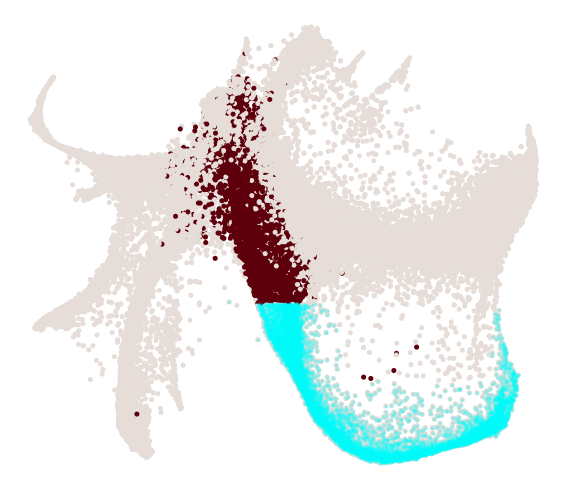

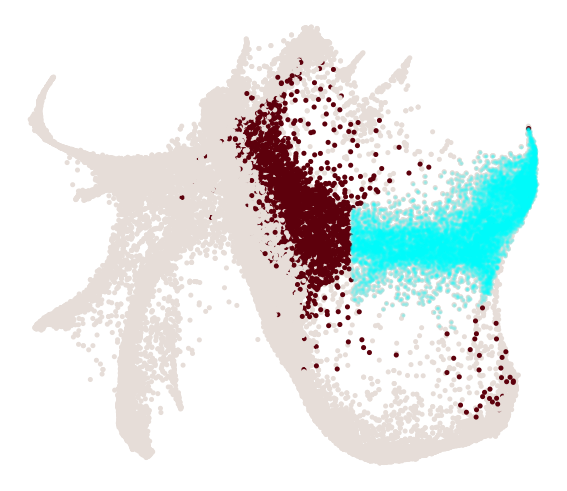

In [19]:
cs.tl.progenitor(
    adata,
    selected_fates=["Neutrophil", "Monocyte"],
    source="transition_map",
    map_backward=True,
    bias_threshold_A=0.5,
    bias_threshold_B=0.5,
    sum_fate_prob_thresh=0.2,
    avoid_target_states=True,
)
cs.pl.progenitor(
    adata, selected_fates=["Neutrophil", "Monocyte"], source="transition_map"
)

#### Gene trend along the dynamic trajectory

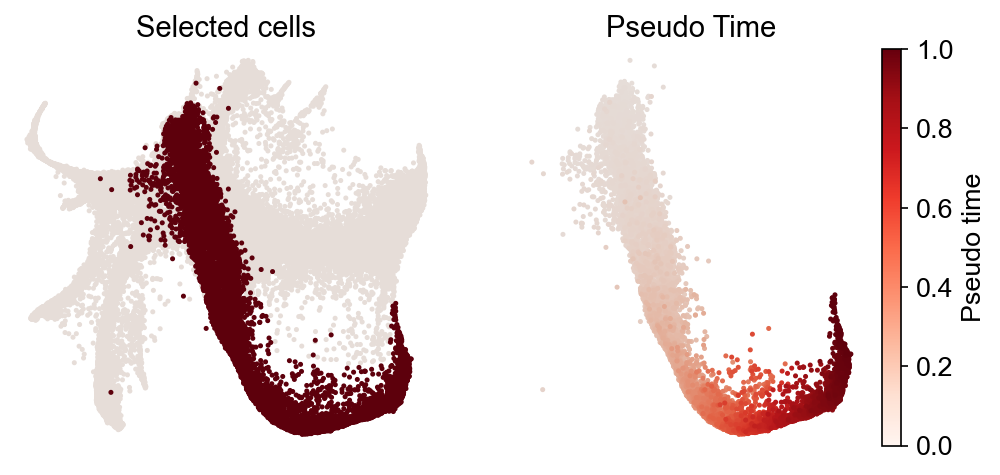

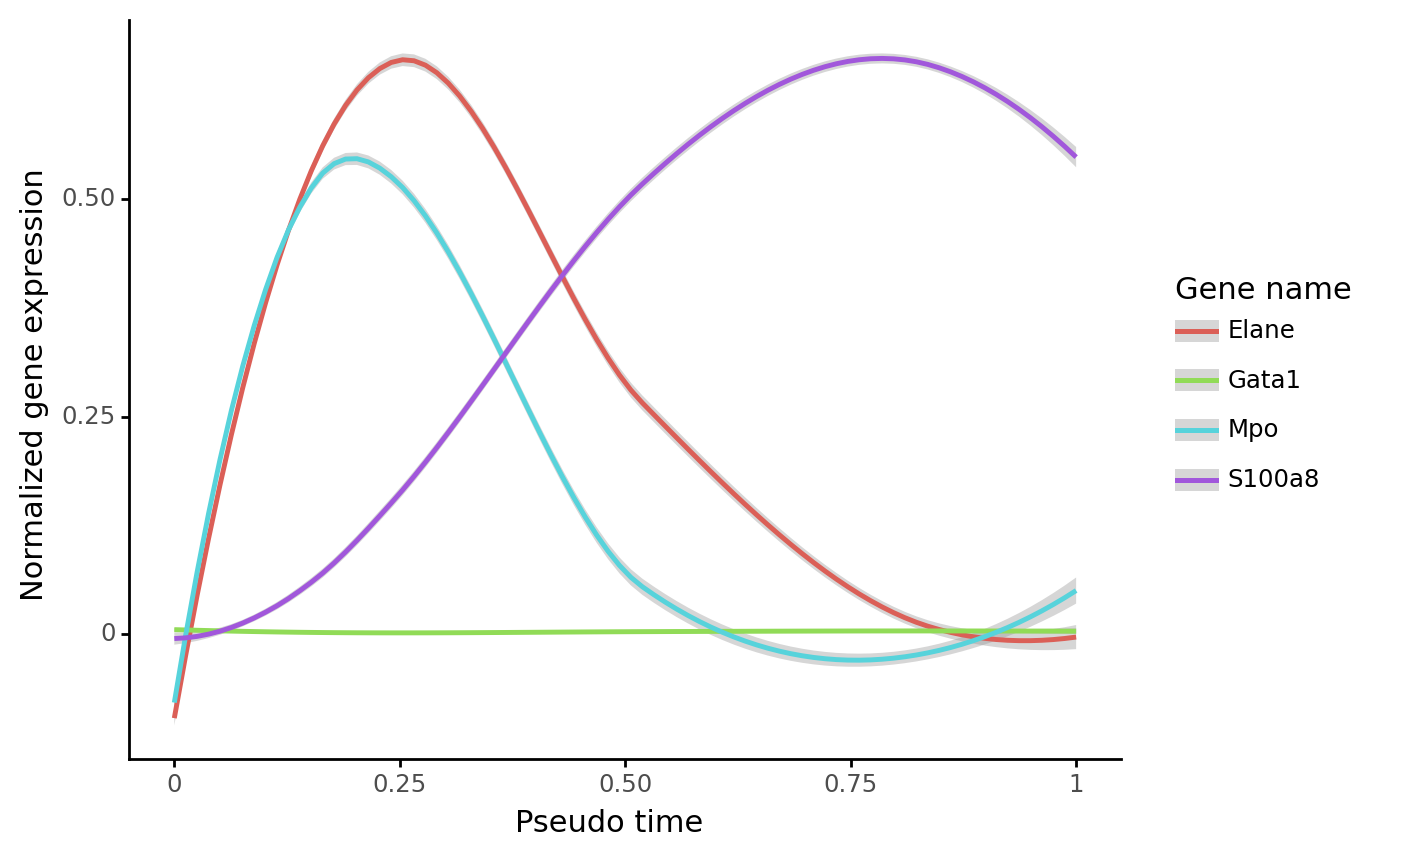

In [20]:
gene_name_list = ["Gata1", "Mpo", "Elane", "S100a8"]
selected_fate = "Neutrophil"
cs.pl.gene_expression_dynamics(
    adata, selected_fate, gene_name_list, traj_threshold=0.2, invert_PseudoTime=False
)

## Part II: Infer transition map from end-point clones

When run for the firs time, assuming that the similarity matrices are pre-computed, it takes 73 mins. Around 40 mins of which are used to compute the initialized map.

We group time points '2' and '4' so that the inference on day 2 states (which has much fewer cells) are better. 

In [21]:
time_info = np.array(adata_orig.obs["time_info"])
time_info[time_info == "2"] = "24"
time_info[time_info == "4"] = "24"
adata_orig.obs["time_info"] = time_info
adata_orig = cs.pp.initialize_adata_object(adata_orig)

Clones without any cells are removed.
Time points with clonal info: ['24' '6']


In [22]:
adata_1 = cs.tmap.infer_Tmap_from_one_time_clones(
    adata_orig,
    initial_time_points=["24"],
    later_time_point="6",
    initialize_method="OT",
    OT_cost="GED",
    smooth_array=[20, 15, 10],
    max_iter_N=[1, 3],
    sparsity_threshold=0.2,
    use_full_Smatrix=True,
)

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: 24--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed custom OT matrix
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.974
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.144
Finishing Joint Optimization, used time 1308.7951350212097
-----------Total used time: 1341.8913249969482 s ------------


### Fate bias

Results saved at adata.obs['fate_map_transition_map_Neutrophil']
Results saved at adata.obs['fate_map_transition_map_Monocyte']
Results saved at adata.obs['fate_bias_transition_map_Neutrophil*Monocyte']


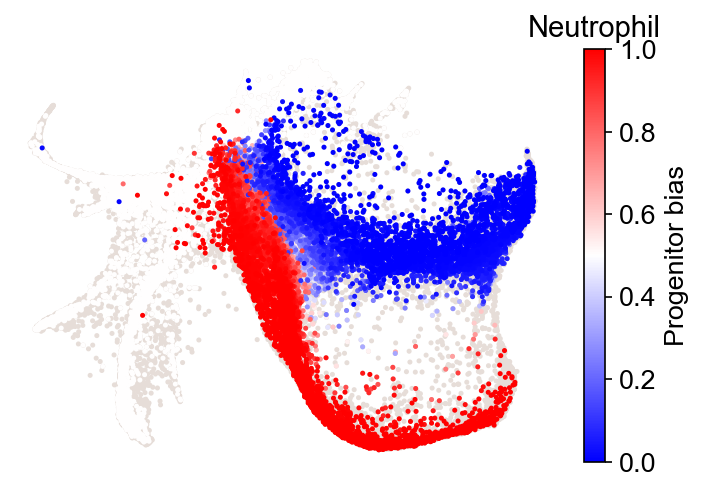

In [23]:
cs.tl.fate_bias(
    adata_1,
    selected_fates=["Neutrophil", "Monocyte"],
    source="transition_map",
    pseudo_count=0,
    sum_fate_prob_thresh=0.1,
)
cs.pl.fate_bias(
    adata_1,
    selected_fates=["Neutrophil", "Monocyte"],
    source="transition_map",
    plot_target_state=False,
)

## Part III: Infer transition map from state information alone

In [24]:
adata_2 = cs.tmap.infer_Tmap_from_state_info_alone(
    adata_orig,
    initial_time_points=["24"],
    later_time_point="6",
    initialize_method="OT",
    OT_cost="GED",
    smooth_array=[20, 15, 10],
    max_iter_N=[1, 3],
    sparsity_threshold=0.2,
    use_full_Smatrix=True,
)

Step I: Generate pseudo clones where each cell has a unique barcode-----


Trying to set attribute `.uns` of view, copying.


Step II: Perform joint optimization-----


Trying to set attribute `.uns` of view, copying.


--------Infer transition map between initial time points and the later time one-------
--------Current initial time point: 24--------
Step 0: Pre-processing and sub-sampling cells-------
Step 1: Use OT method for initialization-------
Load pre-computed custom OT matrix
Step 2: Jointly optimize the transition map and the initial clonal states-------
-----JointOpt Iteration 1: Infer initial clonal structure
-----JointOpt Iteration 1: Update the transition map by CoSpar
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.977
Convergence (JointOpt, iter_N=1): corr(previous_T, current_T)=0.14
Finishing Joint Optimization, used time 1854.5912249088287
-----------Total used time: 1923.1848938465118 s ------------


Results saved at adata.obs['fate_map_transition_map_Neutrophil']
Results saved at adata.obs['fate_map_transition_map_Monocyte']
Results saved at adata.obs['fate_bias_transition_map_Neutrophil*Monocyte']


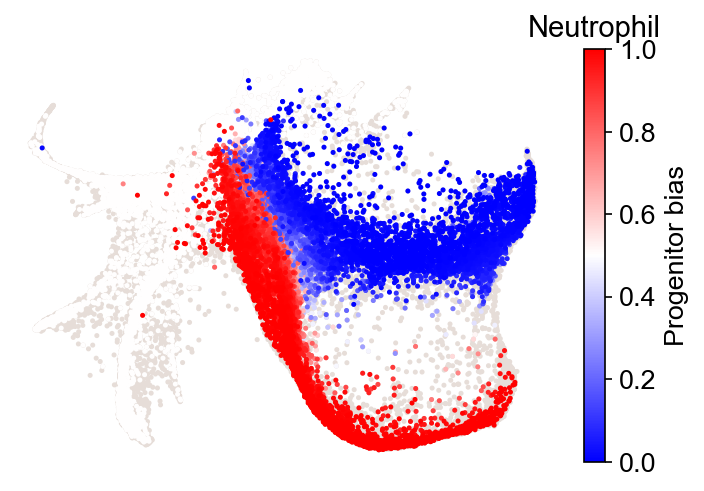

In [25]:
cs.tl.fate_bias(
    adata_2,
    selected_fates=["Neutrophil", "Monocyte"],
    source="transition_map",
    pseudo_count=0,
    sum_fate_prob_thresh=0.1,
)
cs.pl.fate_bias(
    adata_2,
    selected_fates=["Neutrophil", "Monocyte"],
    source="transition_map",
    plot_target_state=False,
)

## Part IV: Predict fate bias for Gata1+ states

### Load data

We load a dataset that also includes non-clonally labeled cells in the Gata1+ states (in total ~38K cells),  which increases the statistical power of DGE analysis.

In [26]:
cs.settings.data_path = "LARRY_data_Gata1"  # A relative path to save data. If not existed before, create a new one.
cs.settings.figure_path = "LARRY_figure_Gata1"  # A relative path to save figures. If not existed before, create a new one.
adata_orig_1 = cs.datasets.hematopoiesis_Gata1_states()

In [27]:
adata_orig_1 = cs.pp.initialize_adata_object(adata_orig_1)

Time points with clonal info: ['2' '4' '6']


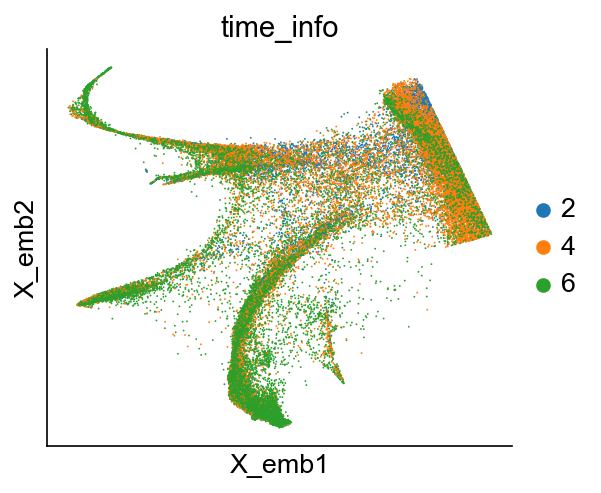

In [28]:
cs.pl.embedding(adata_orig_1, color="time_info")

In [29]:
adata_orig_1

AnnData object with n_obs × n_vars = 38457 × 25289
    obs: 'n_counts', 'Source', 'Well', 'mito_frac', 'time_info', 'state_info'
    var: 'highly_variable'
    uns: 'AllCellCyc_genes', 'clonal_time_points', 'data_des', 'max_mito', 'min_tot', 'new_highvar_genes', 'state_info_colors', 'time_info_colors', 'time_ordering'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_umap'

In [30]:
## This is for testing this notebook
# adata_orig_1=adata_orig
# adata_3=adata_1

### Infer transition map from all clones

In [31]:
adata_3 = cs.tmap.infer_Tmap_from_multitime_clones(
    adata_orig_1,
    later_time_point="6",
    smooth_array=[20, 15, 10],
    sparsity_threshold=0.1,
    intraclone_threshold=0.1,
    extend_Tmap_space=True,
)

------Compute the full Similarity matrix if necessary------


Trying to set attribute `.uns` of view, copying.


------Infer transition map between initial time points and the later time one------
--------Current initial time point: 2--------
Step 1: Select time points
Number of multi-time clones post selection: 355
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.969
--------Current initial time point: 4--------
Step 1: Select time points
Number of multi-time clones post selection: 1270
Step 2: Optimize the transition map recursively
Load pre-computed similarity matrix
Iteration 1, Use smooth_round=20
Iteration 2, Use smooth_round=15
Iteration 3, Use smooth_round=10
Convergence (CoSpar, iter_N=3): corr(previous_T, current_T)=0.985
-----------Total used time: 477.8539500236511 s ------------


### Fate bias

Results saved at adata.obs['fate_map_transition_map_Meg_Erythroid']
Results saved at adata.obs['fate_map_transition_map_Baso_Mast_Eos']
Results saved at adata.obs['fate_bias_transition_map_Meg_Erythroid*Baso_Mast_Eos']


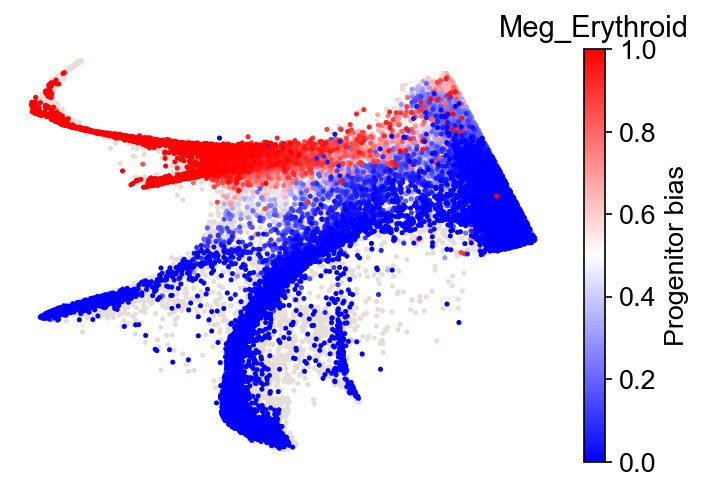

In [32]:
selected_fates = [["Meg", "Erythroid"], ["Baso", "Mast", "Eos"]]
cs.tl.fate_bias(
    adata_3,
    selected_fates=selected_fates,
    source="transition_map",
    pseudo_count=0,
    sum_fate_prob_thresh=0.05,
)
cs.pl.fate_bias(
    adata_3,
    selected_fates=selected_fates,
    source="transition_map",
    plot_target_state=False,
)

### Identify ancestor populations

<AxesSubplot:>

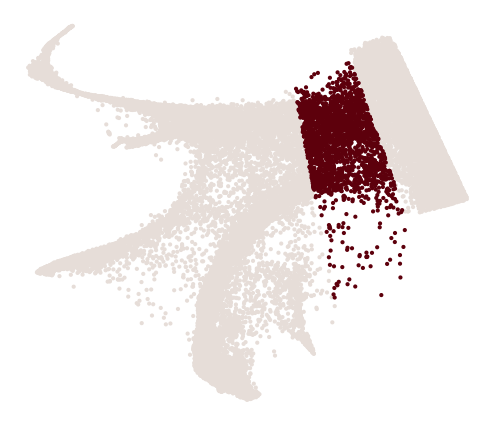

In [33]:
x_emb = adata_orig_1.obsm["X_emb"][:, 0]
y_emb = adata_orig_1.obsm["X_emb"][:, 1]

index_2 = cs.hf.above_the_line(adata_orig_1.obsm["X_emb"], [0, -500], [-300, 1000])
index_2_2 = cs.hf.above_the_line(adata_orig_1.obsm["X_emb"], [-450, -600], [-600, 800])

final_mask = (index_2_2) & (~index_2)  # & index_3 & index_4 & index_5 #mask_1 &
cs.pl.customized_embedding(x_emb, y_emb, final_mask)

Results saved at adata.obs['fate_map_transition_map_Meg_Erythroid']
Results saved at adata.obs['fate_map_transition_map_Baso_Mast_Eos']
Results saved at adata.obs['fate_bias_transition_map_Meg_Erythroid*Baso_Mast_Eos']
Results saved at adata.obs[f'progenitor_transition_map_Meg_Erythroid'] and adata.obs[f'diff_trajectory_transition_map_Meg_Erythroid']
Results saved at adata.obs[f'progenitor_transition_map_Baso_Mast_Eos'] and adata.obs[f'diff_trajectory_transition_map_Baso_Mast_Eos']


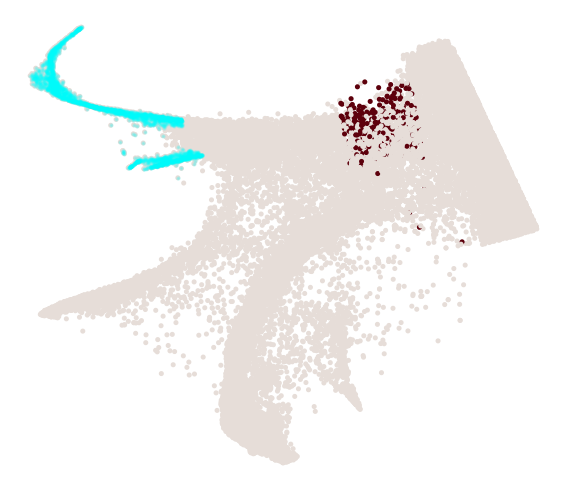

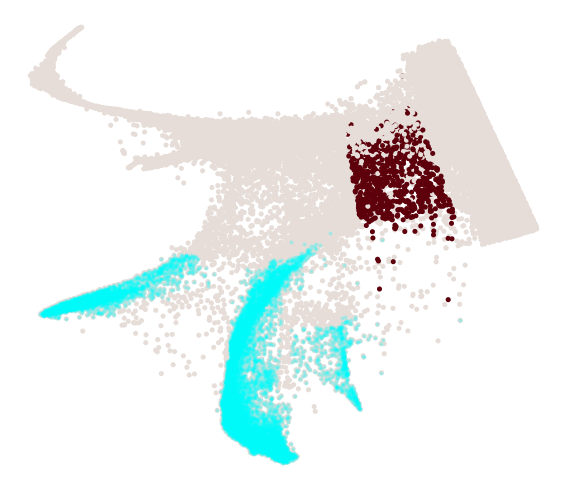

In [34]:
selected_fates = [["Meg", "Erythroid"], ["Baso", "Mast", "Eos"]]
cs.tl.progenitor(
    adata_3,
    selected_fates=selected_fates,
    source="transition_map",
    map_backward=True,
    bias_threshold_A=0.6,
    bias_threshold_B=0.3,
    sum_fate_prob_thresh=0.05,
    avoid_target_states=True,
)
cs.pl.progenitor(
    adata_3, selected_fates=selected_fates, source="transition_map", mask=final_mask
)

### DGE analysis

In [35]:
cell_group_A = np.array(adata_3.obs[f"progenitor_transition_map_Meg_Erythroid"])
cell_group_B = np.array(adata_3.obs[f"progenitor_transition_map_Baso_Mast_Eos"])
dge_gene_A, dge_gene_B = cs.tl.differential_genes(
    adata_3, cell_group_A=cell_group_A, cell_group_B=cell_group_B, FDR_cutoff=0.05
)

In [36]:
# All, ranked, DGE genes for group A
dge_gene_A

,index,gene,Qvalue,mean_1,mean_2,ratio
0,4,Ctsg,0.000000e+00,0.103370,2.567811,-1.693123
1,3,Emb,0.000000e+00,0.186135,2.703714,-1.642705
2,26,Elane,3.264509e-241,0.151518,2.530409,-1.616299
3,2,Plac8,0.000000e+00,1.096986,4.811569,-1.470611
4,17,Igfbp4,0.000000e+00,1.042382,3.969988,-1.282990
...,...,...,...,...,...,...
965,2772,Rps29,2.823620e-02,2.905993,3.008932,-0.037529
966,2343,Rpl38,8.297305e-03,5.915980,6.061140,-0.029967
967,2976,Rpl5,4.697313e-02,4.714540,4.806636,-0.023065
968,2544,Ly6e,1.556172e-02,2.882883,2.944137,-0.022582


In [37]:
sub_predicted_upper = [
    "Slc14a1",
    "Plxnc1",
    "Mef2c",
    "Tnip3",
    "Pbx1",
    "Hbb-bt",
    "Tmem176b",
    "Car2",
    "Pim2",
    "Tsc22d1",
    "Plcg2",
    "Gmpr",
    "Cd44",
    "Irgm1",
    "Hsd17b10",
    "Dlk1",
]
sub_predicted_lower = [
    "Ctsg",
    "Emb",
    "Ccl9",
    "Igfbp7",
    "Ap3s1",
    "Gstm1",
    "Ms4a3",
    "Fcgr3",
    "Mpo",
    "Cebpb",
    "Thy1",
    "Anxa3",
    "Sell",
    "Pcsk9",
    "Fcgr2b",
    "Cebpa",
    "Cxcr4",
]

In [38]:
state_info = np.array(adata_3.obs["state_info"])
state_info[cell_group_A > 0] = "MegEr_Prog"
state_info[cell_group_B > 0] = "EMB_Prog"

/Users/shouwenwang/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'state_info' as categorical


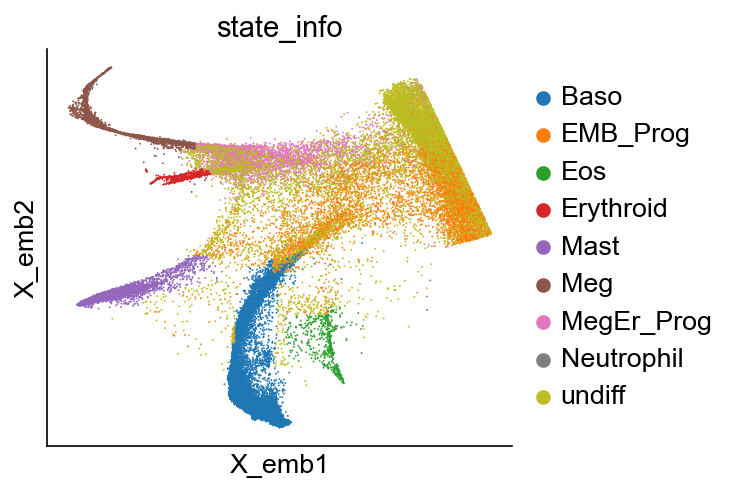

In [39]:
adata_3.obs["state_info"] = state_info
cs.pl.embedding(adata_3, color="state_info")

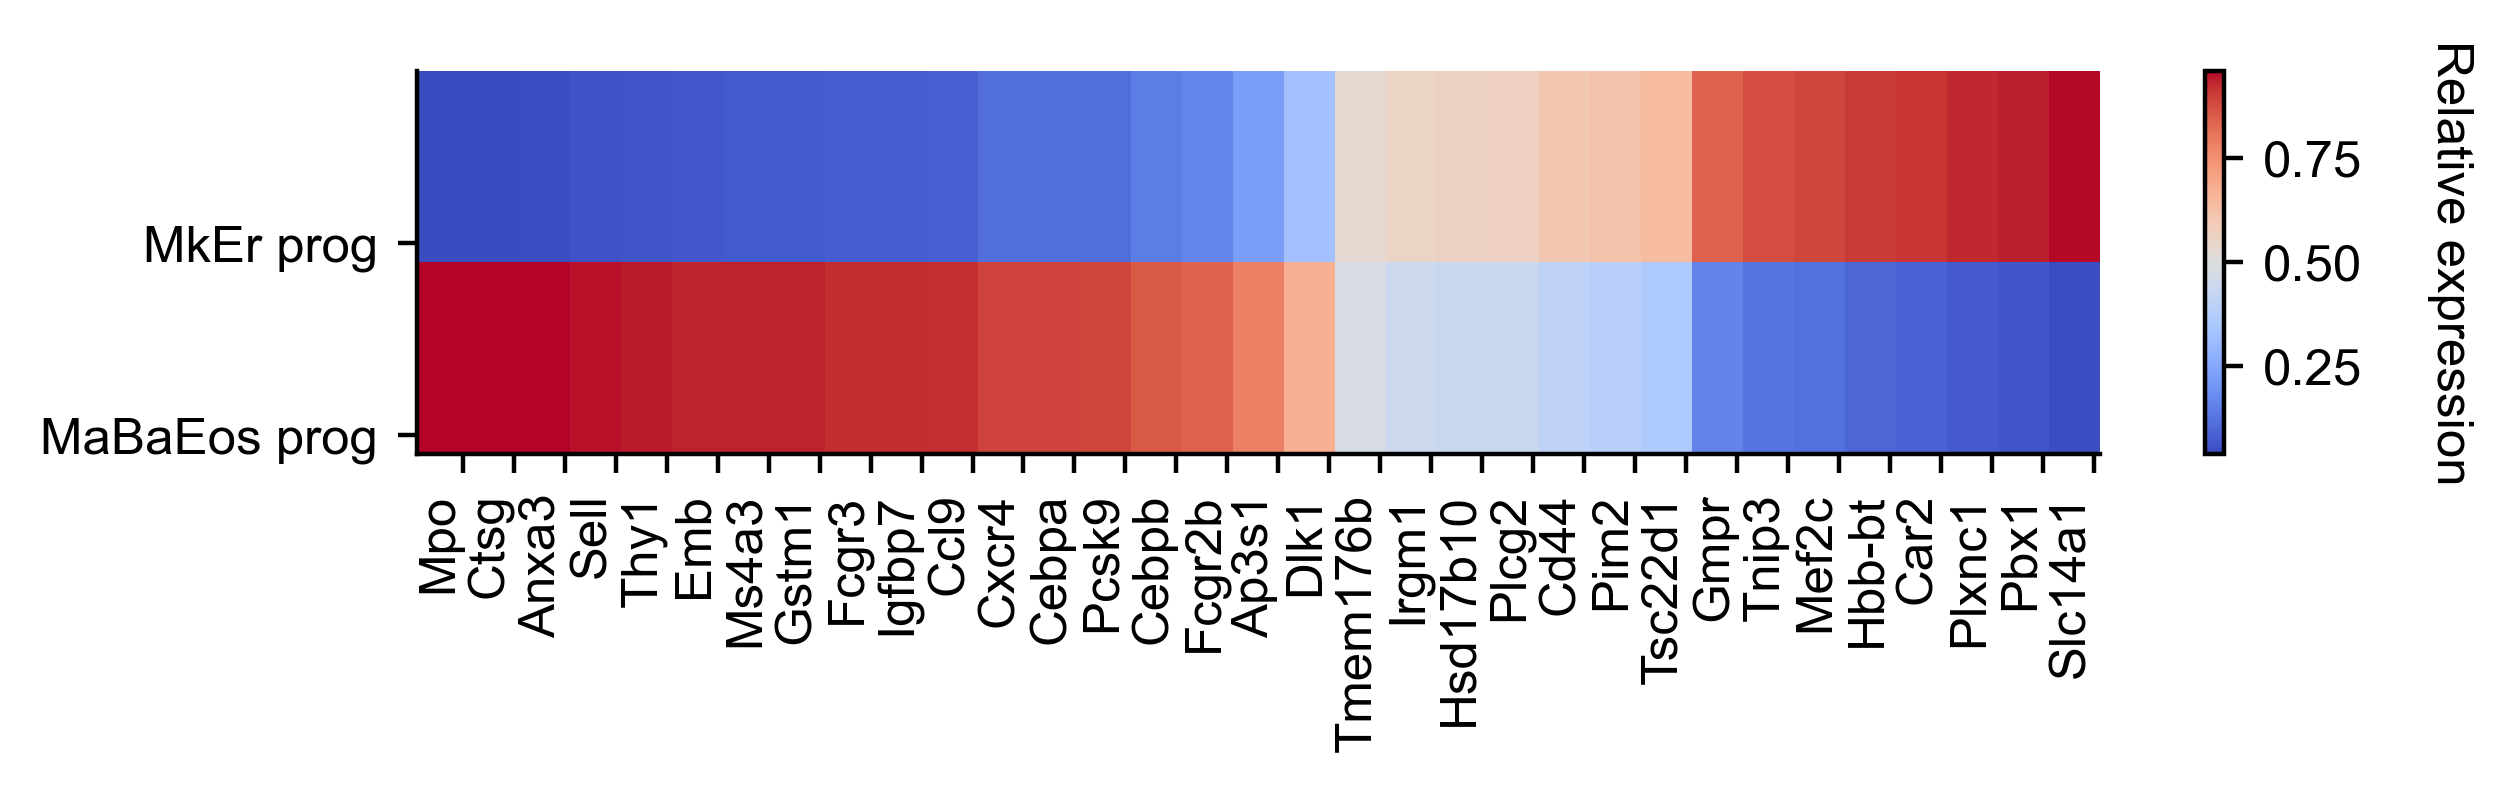

In [40]:
cs.settings.set_figure_params(
    format="pdf", figsize=[4, 3.5], dpi=200, fontsize=10, pointsize=3
)

gene_list = sub_predicted_upper + sub_predicted_lower
selected_fates = ["MegEr_Prog", "EMB_Prog"]
renames = ["MkEr prog", "MaBaEos prog"]

gene_expression_matrix = cs.pl.gene_expression_heatmap(
    adata_3,
    selected_genes=gene_list,
    selected_fates=selected_fates,
    rename_fates=renames,
    horizontal=True,
    fig_width=6.5,
    fig_height=2,
)